In [18]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sharespotify/spotify_data.csv


In [19]:
# Import other needed packages

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [20]:
spotifydf = pd.read_csv('/kaggle/input/sharespotify/spotify_data.csv')

# Data Cleaning and Processing

In [21]:
spotifydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17774 entries, 0 to 17773
Data columns (total 39 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   artist_name                   17774 non-null  object 
 1   artist_id                     17774 non-null  object 
 2   album_id                      17774 non-null  object 
 3   album_type                    17774 non-null  object 
 4   album_images                  0 non-null      float64
 5   album_release_date            17774 non-null  object 
 6   album_release_year            17289 non-null  float64
 7   album_release_date_precision  17774 non-null  object 
 8   danceability                  17774 non-null  float64
 9   energy                        17774 non-null  float64
 10  key                           17774 non-null  int64  
 11  loudness                      17774 non-null  float64
 12  mode                          17774 non-null  int64  
 13  s

In [22]:
# Dropping columns with entire null values
spotifydf = spotifydf.drop(columns=['album_images','artists','available_markets'])

In [23]:
# Replacing null values in track_preview_url
spotifydf[['track_preview_url']] = spotifydf[['track_preview_url']].fillna('notSpecified')

In [24]:
# Getting year from album_release_date to fill in nulls in album_release_year...


# Convert album_release_date to datetime format
spotifydf['album_release_date'] = pd.to_datetime(spotifydf['album_release_date'], format='ISO8601')
# Extract the year from album_release_date
spotifydf['extracted_year'] = spotifydf['album_release_date'].dt.year
# Fill the null values in album_release_year with the extracted year
spotifydf['album_release_year'].fillna(spotifydf['extracted_year'], inplace=True)
# Drop the temporary extracted_year column
spotifydf.drop(columns=['extracted_year'], inplace=True)

/tmp/ipykernel_33/2711608882.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  spotifydf['album_release_year'].fillna(spotifydf['extracted_year'], inplace=True)


In [25]:
# Check null values again
spotifydf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17774 entries, 0 to 17773
Data columns (total 36 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   artist_name                   17774 non-null  object        
 1   artist_id                     17774 non-null  object        
 2   album_id                      17774 non-null  object        
 3   album_type                    17774 non-null  object        
 4   album_release_date            17774 non-null  datetime64[ns]
 5   album_release_year            17774 non-null  float64       
 6   album_release_date_precision  17774 non-null  object        
 7   danceability                  17774 non-null  float64       
 8   energy                        17774 non-null  float64       
 9   key                           17774 non-null  int64         
 10  loudness                      17774 non-null  float64       
 11  mode                        

In [26]:
# Count the number of duplicate rows
spotifydf.duplicated().sum()

0

# Descriptive Analysis

In [27]:
# Adding column for count
spotifydf['count'] = 1

In [28]:
# Top 10 most popular artists
popartists = pd.DataFrame(spotifydf.groupby('artist_name')['count'].sum()).reset_index()
popartists.sort_values(by='count', ascending=False).head(10)

,artist_name,count
34,Queen,1703
15,Frank Sinatra,1678
35,Quincy Jones,1337
36,Rod Stewart,1335
47,Tony Bennett,1238
31,Oasis,1066
43,The Beatles,801
3,Beyoncé,702
5,Blur,570
49,alt-J,526


In [29]:
# Number of artists
len(spotifydf['artist_id'].unique())

50

In [30]:
# Number of tracks
len(spotifydf['track_id'].unique())

17774

In [31]:
# Number of albums
len(spotifydf['album_id'].unique())

1131

# Histogram - Songs by Album Year

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


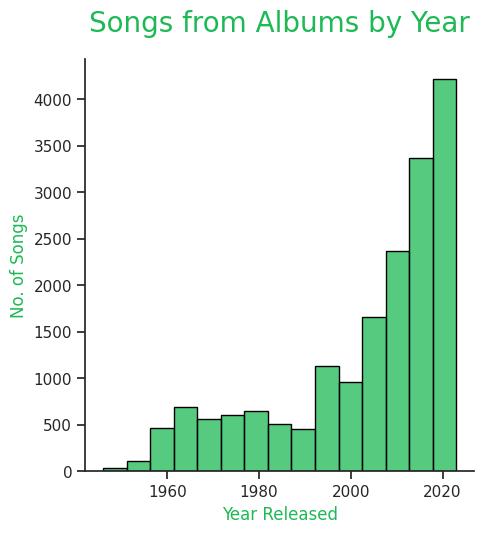

In [32]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.displot(spotifydf['album_release_year'], kde = False, bins = 15, color = '#1DB954', edgecolor= 'black')
plt.title('Songs from Albums by Year', fontdict={'fontsize':20, 'color':'#1DB954'}, pad=20)
plt.xlabel('Year Released', color = '#1DB954')
plt.ylabel('No. of Songs', color ='#1DB954')
plt.savefig('songs_year')
plt.show()

# Boxplot - Audio Feature Variable (AFV) distribution

In [33]:
# Get descriptive stats for the AFVs
spotifydf.describe()

,album_release_date,album_release_year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,disc_number,duration_ms,track_number,count
count,17774,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,17774.000000,1.777400e+04,17774.000000,17774.0
mean,2003-05-21 01:30:49.217958784,2002.950039,0.497791,0.546673,5.203725,-10.166598,0.669855,0.092338,0.397957,0.181127,0.276473,0.423110,116.644303,3.871723,1.251041,2.364050e+05,8.149882,1.0
min,1946-03-04 00:00:00,1946.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000e+03,1.000000,1.0
25%,1994-11-30 00:00:00,1994.000000,0.357000,0.334000,2.000000,-12.687000,0.000000,0.034600,0.049025,0.000002,0.105000,0.212000,93.052000,4.000000,1.000000,1.750962e+05,4.000000,1.0
50%,2010-10-13 12:00:00,2010.000000,0.504000,0.558000,5.000000,-9.326500,1.000000,0.044950,0.310000,0.000875,0.160000,0.394000,116.112500,4.000000,1.000000,2.253600e+05,7.000000,1.0
75%,2017-06-09 00:00:00,2017.000000,0.635000,0.763000,8.000000,-6.782000,1.000000,0.080475,0.746000,0.196000,0.351000,0.611000,135.101500,4.000000,1.000000,2.804980e+05,11.000000,1.0
max,2023-04-28 00:00:00,2023.000000,0.968000,0.999000,11.000000,-1.067000,1.000000,0.962000,0.996000,1.000000,1.000000,0.991000,229.935000,5.000000,14.000000,4.497994e+06,69.000000,1.0
std,NaN,18.485950,0.183678,0.257225,3.539453,4.711492,0.470278,0.127491,0.349595,0.315517,0.252889,0.248102,29.972995,0.505388,0.914196,1.134044e+05,6.029965,0.0


## Means:
* danceability: 0.50
* energy: 0.55
* loudness: -10.17
* speechiness: 0.09
* acousticness: 0.40
* instrumentalness: 0.18
* liveness: 0.28 
* valence: 0.42

In [34]:
# Reshape data so that the AFVs are all part of one 'feature' column
features = ['acousticness','danceability','energy','instrumentalness','liveness','speechiness']

spotifymelt = spotifydf.melt(id_vars=['track_id','artist_name', 'album_name', 'album_release_year', 'explicit', 'track_name'],
                             value_vars=features, var_name='feature', value_name='value')
spotifymelt

,track_id,artist_name,album_name,album_release_year,explicit,track_name,feature,value
0,6XOG65nZN3XKmxevGRHZMC,Four Tet,Parallel,2020.0,False,Parallel 1,acousticness,0.92200
1,2sJSXoJaTbY2SGqiAEpw96,Four Tet,Parallel,2020.0,False,Parallel 2,acousticness,0.02840
2,0P5SYXWSgFTsSIKzWelMyh,Four Tet,Parallel,2020.0,False,Parallel 3,acousticness,0.98800
3,1ZeDNZoKgEOTRmTTg1zQd4,Four Tet,Parallel,2020.0,False,Parallel 4,acousticness,0.02270
4,6KUe36MHFyTKRU7iZDn7LT,Four Tet,Parallel,2020.0,False,Parallel 5,acousticness,0.00364
...,...,...,...,...,...,...,...,...
106639,7jYDnZbPuStlOxYV086moY,Bombay Bicycle Club,I Had The Blues But I Shook Them Loose,2009.0,False,Cancel On Me,speechiness,0.03830
106640,5yBkl134dzPqO6uENh1BC1,Bombay Bicycle Club,I Had The Blues But I Shook Them Loose,2009.0,False,Autumn,speechiness,0.04990
106641,3coaEPXYRFausimLB5omSn,Bombay Bicycle Club,I Had The Blues But I Shook Them Loose,2009.0,False,The Hill,speechiness,0.05310
106642,1Gjhq1MYeBLfFc5g4oYSmy,Bombay Bicycle Club,I Had The Blues But I Shook Them Loose,2009.0,False,What If,speechiness,0.03240


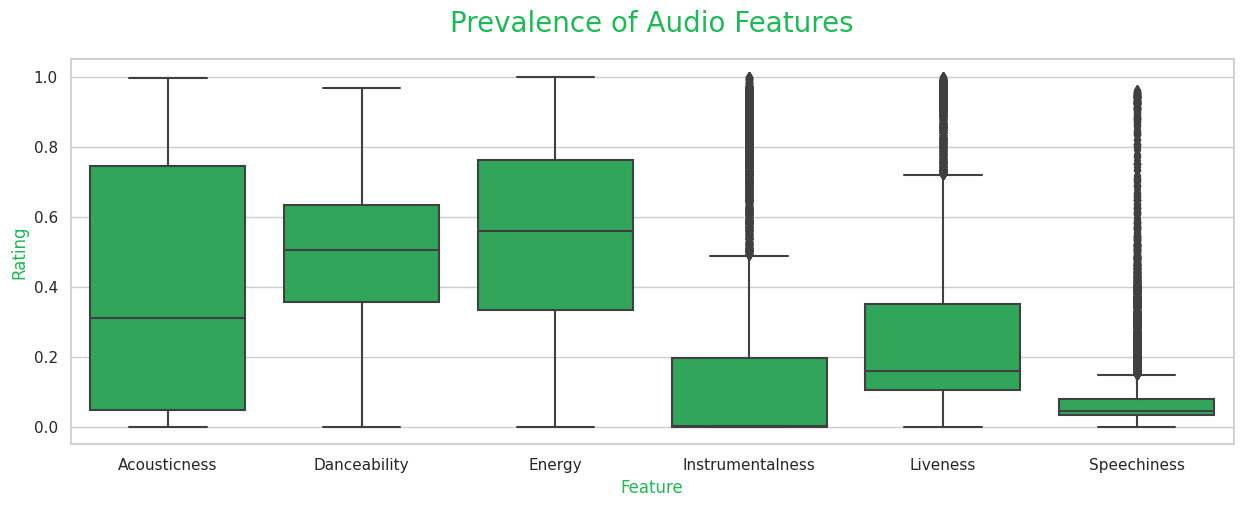

In [35]:
plt.figure(figsize=(15,5))
sns.set_style('whitegrid')
sns.set_context('notebook')
sns.boxplot(x='feature', y='value', data=spotifymelt, color = '#1DB954')
plt.title('Prevalence of Audio Features', fontdict={'fontsize':20, 'color':'#1DB954'}, pad=20)
plt.xlabel('Feature', color='#1DB954')
plt.ylabel('Rating', color='#1DB954')
customlabels = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Liveness', 'Speechiness']
plt.xticks(ticks=range(len(customlabels)), labels=customlabels)
plt.savefig('boxplotafv')
plt.show()

# Clustermap - Correlations based on AFV similarity

In [36]:
# Correlate the features
spotifymx = spotifydf[features].corr()

In [37]:
# Create colourmap for aesthetics and synergy
from matplotlib.colors import LinearSegmentedColormap
spotifycmap = LinearSegmentedColormap.from_list('custom',['#edfcf2','#98efb6','#1DB954'])

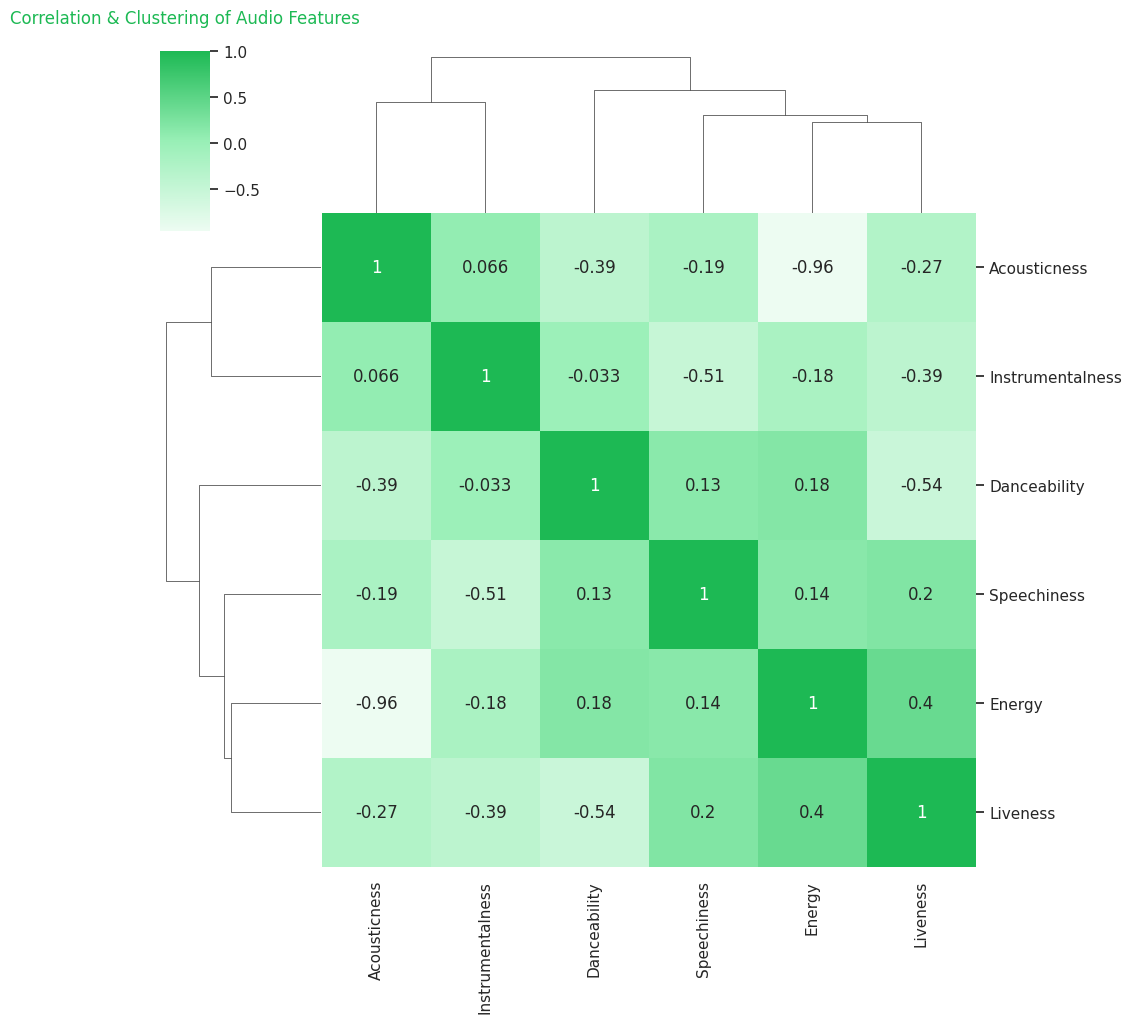

In [38]:
sns.set_context('notebook')

sns.clustermap(spotifymx.corr(), annot=True, cmap=spotifycmap, method='average',
              xticklabels=customlabels,
              yticklabels=customlabels)
plt.title('Correlation & Clustering of Audio Features', color='#1DB954', pad=20)
plt.savefig('clusterafv')
plt.show()

# Line Chart - Time Series analysis of AFVs

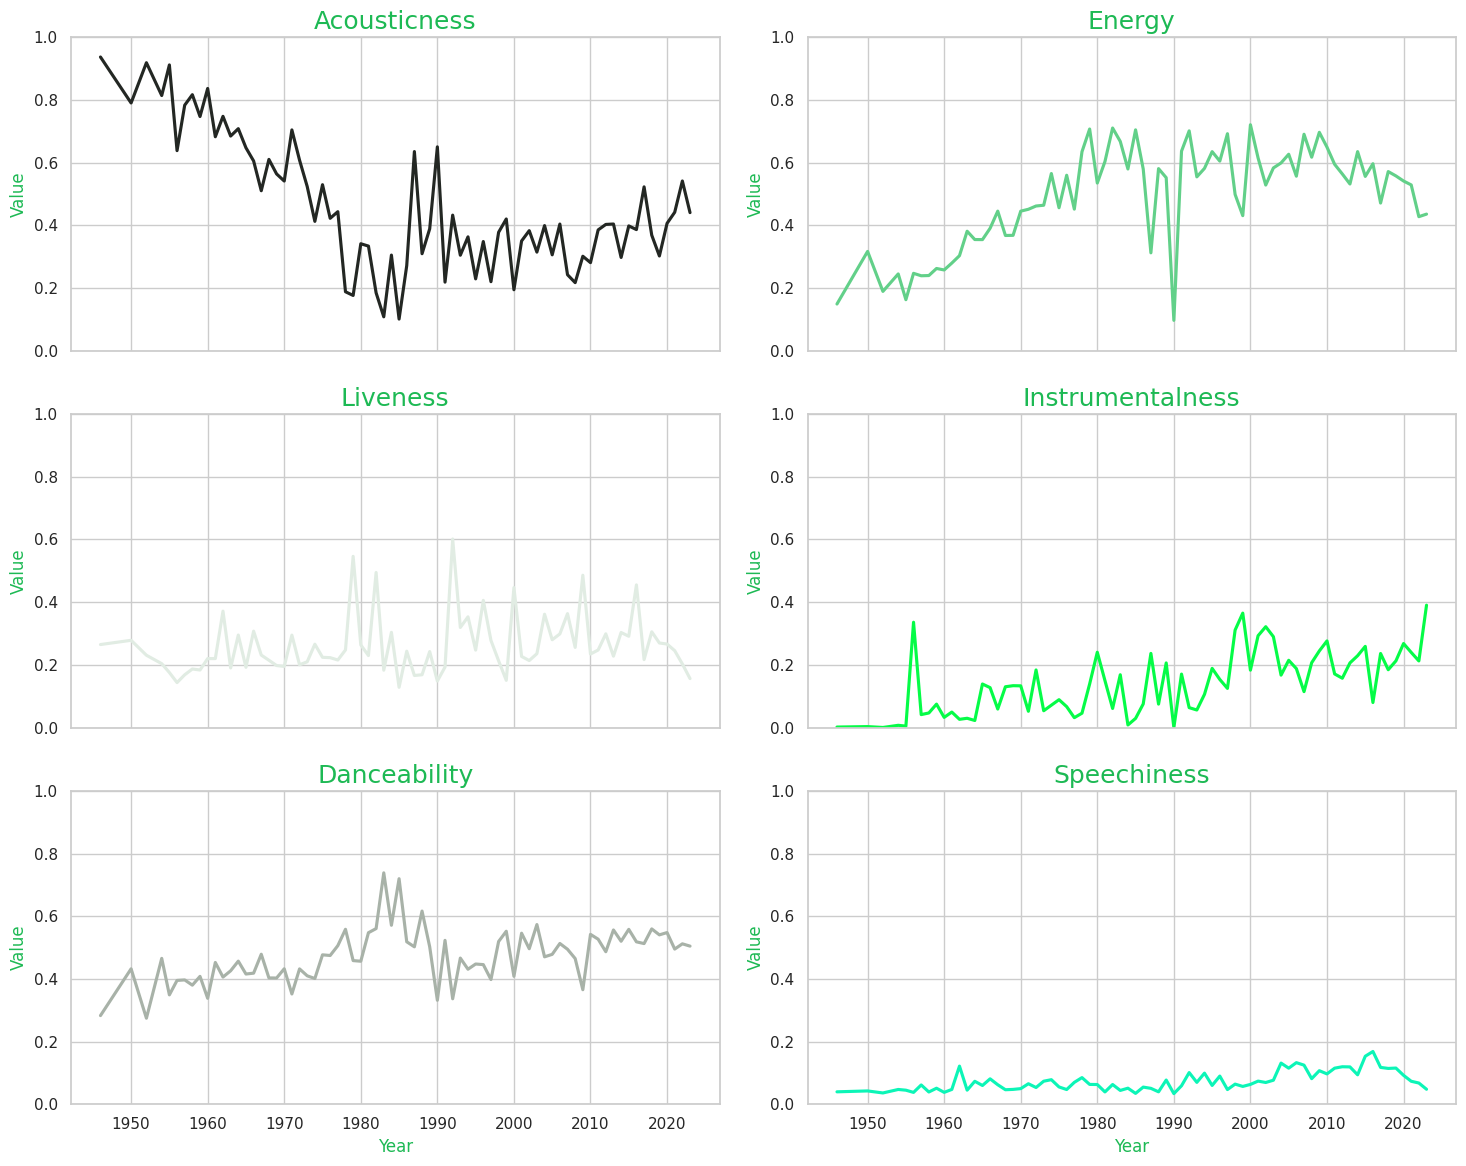

In [39]:
# Create a 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 12), sharex=True)

sns.set_context('talk')

# Define the features, colors, and titles
features = ['acousticness', 'energy', 'liveness', 'instrumentalness', 'danceability', 'speechiness']
colors = ['#232723', '#62d089', '#e1ece3', '#05fc47', '#a8b2a8', '#0cf5b7']
titles = ['Acousticness', 'Energy', 'Liveness', 'Instrumentalness', 'Danceability', 'Speechiness']

# Plot each feature in a separate subplot
for ax, feature, color, title in zip(axs.flat, features, colors, titles):
    # Plot the feature
    spotifydf.groupby('album_release_year')[feature].mean().plot(kind='line', ax=ax, color=color)
    # Set the title and labels
    ax.set_title(title, color='#1DB954')
    ax.set_xlabel('Year', color='#1DB954')
    ax.set_ylabel('Value', color='#1DB954')
    # Set the y-axis limits
    ax.set_ylim(0, 1)

# Adjust the layout to prevent overlap
plt.tight_layout()

plt.savefig('afv_years')

plt.show()

# Clustering using K-means and PCA

In [40]:
# Select the relevant features
features2 = spotifydf[['danceability', 'energy', 'loudness','instrumentalness','acousticness',
                      'speechiness', 'liveness', 'tempo']]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features2)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

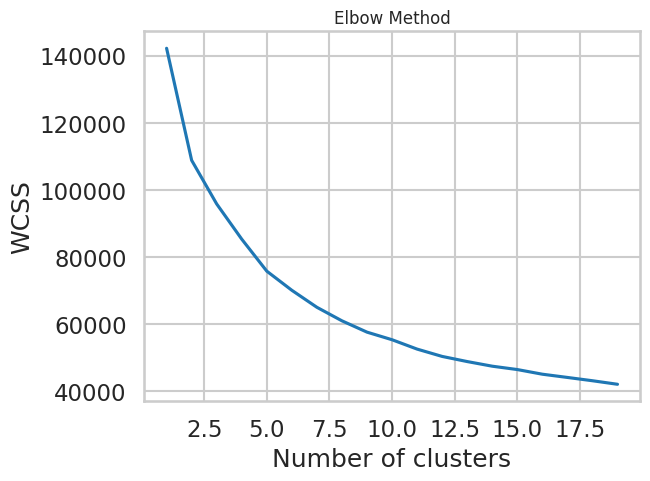

In [41]:
# Determine the optimal number of clusters using the Elbow method
wcss = []
for i in range(1, 20):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow method graph
plt.plot(range(1, 20), wcss)
sns.set_context('notebook')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [42]:
# Fit K-Means with the optimal number of clusters (e.g., k=3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans.fit(scaled_features)
spotifydf['Cluster'] = kmeans.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [43]:
# Reduce dimensions with PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

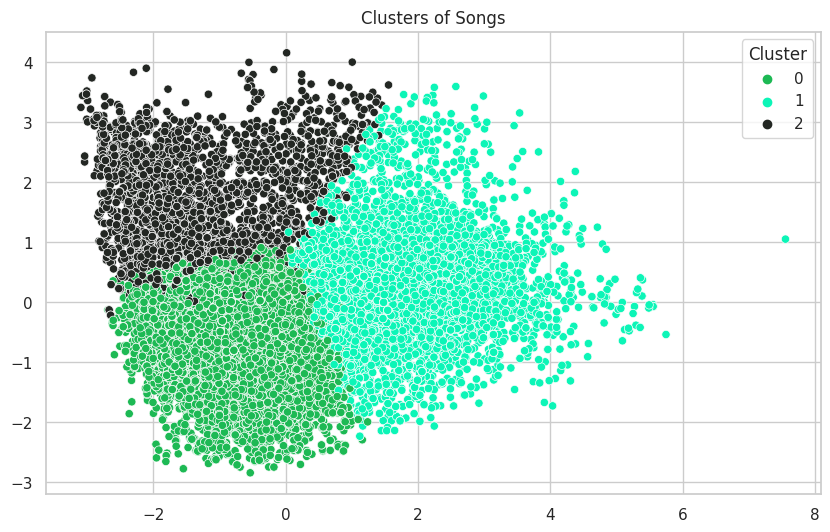

In [44]:
# Create a scatter plot of the clusters
custom_palette = sns.color_palette(['#1DB954', '#0cf5b7', '#232723'])
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=spotifydf['Cluster'], palette=custom_palette)
plt.title('Clusters of Songs')
plt.savefig('clusteredsongs')
plt.show()

In [45]:
# Calculate summary statistics for each feature within each cluster
cluster_summary = spotifydf.groupby('Cluster').agg({
    'danceability': ['mean', 'count'],
    'energy': ['mean'],
    'loudness': ['mean'],
    'instrumentalness': ['mean'],
    'acousticness': ['mean'],
    'speechiness': ['mean'],
    'liveness': ['mean'],
    'tempo': ['mean']
})


print(cluster_summary)

        danceability          energy   loudness instrumentalness acousticness  \
                mean count      mean       mean             mean         mean   
Cluster                                                                         
0           0.590371  8513  0.664992  -8.045228         0.192244     0.185539   
1           0.427863  6262  0.275633 -14.352510         0.199032     0.772836   
2           0.381001  2999  0.776749  -7.448040         0.112184     0.218169   

        speechiness  liveness       tempo  
               mean      mean        mean  
Cluster                                    
0          0.089865  0.174125  119.780604  
1          0.068707  0.209750  108.966992  
2          0.148697  0.706314  123.772011  


## Cluster descriptions:

* 0 - highest danceability/lowest acousticness and liveness
> Name: Electronic Dance Songs
* 1 - highest instrumentalness and acousticness/lowest energy speechiness tempo and loudness
> Name: Chilled Focus Songs
* 2 - highest energy speechiness liveness tempo loudness/lowest danceability and instrumentalness
> Name: Upbeat Singalong Classics

In [46]:
# Calculate silhouette score
silhouette_avg = silhouette_score(scaled_features, spotifydf['Cluster'])
print(f'Silhouette Score: {silhouette_avg}')

Silhouette Score: 0.21440573191612944
